In [1]:
import os

In [2]:
from PIL import Image

# # converting file format to .png
search_terms = ['no smile', 'smile']

# for term in search_terms:
#     orig_path = f'./{term}'
#     new_path = f'./{term}_png'
#     os.makedirs(new_path)
#     for img_filename in os.listdir(orig_path):    
#         if img_filename.endswith('.jpg'):
#             img = Image.open(f'{orig_path}/{img_filename}')
#             img.save(f'{new_path}/{img_filename.replace("jpg", "png")}')

# Using the Image class

In [3]:
# check Pillow version number
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 5.4.1


In [4]:
# load image with Pillow
from PIL import Image

img = Image.open('./smile_png/0.png')

In [5]:
# summarize some details about the image
from __future__ import print_function
print(img.format, img.size, img.mode)

PNG (612, 408) RGB


In [6]:
# show the image
# img.show()

# Reshape

In [7]:
# need to except errors if file size coming in is not as expected
# crop middle, 300x300
# crop_width, crop_height = (300, 300)

# for term in search_terms:
#     orig_path = f'./{term}'
#     new_path = f'./{term}_cropped'
#     os.makedirs(new_path)
#     for img_filename in os.listdir(orig_path):  
#         if img_filename.endswith('.jpg'):
#             img = Image.open(f'{orig_path}/{img_filename}')
#             width, height = img.size
#             crop_left = (width/2) - (crop_width/2)
#             crop_upper = (height/2) - (crop_height/2)
#             crop_right = (width/2) + (crop_width/2)
#             crop_lower = (height/2) + (crop_height/2)
#             img_resized = img.crop((crop_left, crop_upper, crop_right, crop_lower))
#             img_resized.save(f'{new_path}/{img_filename}')

In [8]:
# !pip install face_recognition
# !pip install dlib

In [9]:
import face_recognition

# put it error check if img less than 300x300, or face bigger than 300x300

In [10]:
# height, width = (300, 300)

# # overwritting ones with multiple faces in images

# for term in search_terms:
#     orig_path = f'./{term}'
#     new_path = f'./{term}_grey_crop'
#     os.makedirs(new_path)
#     for img_filename in os.listdir(orig_path):  
#         if img_filename.endswith('.jpg'):
#             img = Image.open(f'{orig_path}/{img_filename}')
#             img_greyscale = img.convert("L")
#             # load image into a numpy array
#             image = face_recognition.load_image_file(f'{orig_path}/{img_filename}')
#             face_locations = face_recognition.face_locations(image) # model = 'cnn' (more accurate but way slower)
#             if len(face_locations) == 1:
#                 top, right, bottom, left = face_locations[0]
#                 face_height_midpoint = (bottom - top)/2 + top
#                 face_width_midpoint = (right - left)/2 + left
#                 crop_locations = (face_width_midpoint-(width/2), 
#                                   face_height_midpoint-(height/2), 
#                                   face_width_midpoint+(width/2), 
#                                   face_height_midpoint+(height/2))
#                 img_resized = img_greyscale.crop(crop_locations)
#                 img_resized.save(f'{new_path}/{img_filename}')
                    
# # then manually looked at the pictures with multiple faces, and kept appropriate ones

In [11]:
# resize only cropped faces
# can later explore different filters for resizing (better for sizing up or down?)

img_width, img_height = (100, 100)

# overwritting ones with multiple faces in images

# for term in search_terms:
#     orig_path = f'./{term}'
#     new_path = f'./{term}_grey_crop_face'
#     os.makedirs(new_path)
#     for img_filename in os.listdir(orig_path):  
#         if img_filename.endswith('.jpg'):
#             img = Image.open(f'{orig_path}/{img_filename}')
#             img_greyscale = img.convert("L")
#             # load image into a numpy array
#             image = face_recognition.load_image_file(f'{orig_path}/{img_filename}')
#             face_locations = face_recognition.face_locations(image) # model = 'cnn' (more accurate but way slower)
#             if len(face_locations) == 1:
#                 top, right, bottom, left = face_locations[0]
#                 box = (left, top, right, bottom)
#                 img_resized = img_greyscale.resize((img_width, img_height), box = box)
#                 img_resized.save(f'{new_path}/{img_filename}')
                    
# then manually looked at the pictures with multiple faces, and kept appropriate ones

In [12]:
# left with 4_494 no_smiles
# left with 5_182 smiles

# Data Preprocessing

In [13]:
# configure random transformations and normalization operations to be done on your image data during training

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Convert Images to NumPy Arrays

In [14]:
# 1000 pictures for now from each smile and no smile

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# also similar functions in pillow, but shape different using img_to_array?

X = []
y = []

for term in search_terms:
    path = f'./{term}_grey_crop_face'
    image_nos = os.listdir(path)
    for image_no in range(0, 4300):
        img = Image.open(f'{path}/{image_nos[image_no]}')
        img_array = img_to_array(img) # this is a Numpy array with shape (300, 300, 1)
        X.append(img_array)
        y.append(term)

In [15]:
# convert to np.array
import numpy as np
X = np.array(X)
y = np.array(y)

In [16]:
X.shape

(8600, 100, 100, 1)

In [17]:
y.shape

(8600,)

In [18]:
X[0].shape

(100, 100, 1)

In [19]:
X[0]

array([[[187.],
        [170.],
        [182.],
        ...,
        [134.],
        [122.],
        [121.]],

       [[183.],
        [174.],
        [165.],
        ...,
        [135.],
        [124.],
        [121.]],

       [[179.],
        [175.],
        [141.],
        ...,
        [133.],
        [126.],
        [120.]],

       ...,

       [[ 49.],
        [ 46.],
        [ 39.],
        ...,
        [ 24.],
        [ 25.],
        [ 27.]],

       [[ 46.],
        [ 44.],
        [ 38.],
        ...,
        [ 24.],
        [ 26.],
        [ 27.]],

       [[ 43.],
        [ 42.],
        [ 37.],
        ...,
        [ 25.],
        [ 26.],
        [ 27.]]], dtype=float32)

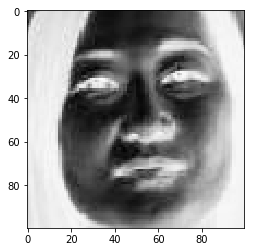

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.imshow(X[0].reshape(img_width, img_height), cmap = 'Greys')

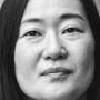

In [21]:
new_image = array_to_img(X[0])
new_image

In [22]:
len(y)

8600

# Train Test Split

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Transforms

In [86]:
from sklearn.preprocessing import MinMaxScaler
X_train = X_train.reshape(X_train.shape[0], img_width*img_height)
X_test = X_test.reshape(X_test.shape[0], img_width*img_height)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [87]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [25]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_test = X_test.reshape(X_test.shape[0], img_width, img_height, 1)

In [26]:
X_train.shape

(6880, 100, 100, 1)

In [27]:
X_test.shape

(1720, 100, 100, 1)

In [28]:
from tensorflow.keras.utils import to_categorical

In [29]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = to_categorical(encoded_y_train)
y_test = to_categorical(encoded_y_test)

In [30]:
y_train[0:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

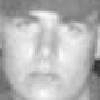

In [31]:
array_to_img(X_train[1])

# Modeling

In [32]:
X_train.shape[1:]

(100, 100, 1)

In [33]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten

In [34]:
# model = Sequential()

# model.add(Input(shape = (img_width, img_height, 1)))
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(2, activation='softmax'))

In [35]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6880, 100, 100, 1)
(1720, 100, 100, 1)
(6880, 2)
(1720, 2)


In [38]:
X_train.shape[1:]

(100, 100, 1)

In [39]:
tf.keras.backend.clear_session()

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
epochs = 100 # for testing, for training use 25
# callbacks=[tf.keras.callbacks.TensorBoard(log_dir = "tb_log", histogram_freq = 0)]

early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience=10, mode='auto', restore_best_weights = True)

history = model.fit_generator(datagen.flow(X_train, y_train),
          epochs = epochs,
          callbacks = [early_stop],
          verbose = 1,
          validation_data = (X_test, y_test))

Epoch 1/100
215/215 [==============================] - 96s 446ms/step - loss: 0.7028 - accuracy: 0.5683 - val_loss: 0.5926 - val_accuracy: 0.7023
Epoch 2/100
215/215 [==============================] - 93s 433ms/step - loss: 0.5884 - accuracy: 0.6892 - val_loss: 0.4653 - val_accuracy: 0.7907
Epoch 3/100
215/215 [==============================] - 87s 403ms/step - loss: 0.5481 - accuracy: 0.7182 - val_loss: 0.4585 - val_accuracy: 0.7814
Epoch 4/100
215/215 [==============================] - 85s 397ms/step - loss: 0.5091 - accuracy: 0.7439 - val_loss: 0.4260 - val_accuracy: 0.8017
Epoch 5/100
215/215 [==============================] - 82s 382ms/step - loss: 0.4921 - accuracy: 0.7597 - val_loss: 0.3900 - val_accuracy: 0.8355
Epoch 6/100
215/215 [==============================] - 87s 405ms/step - loss: 0.4739 - accuracy: 0.7765 - val_loss: 0.4111 - val_accuracy: 0.8093
Epoch 7/100
215/215 [==============================] - 89s 412ms/step - loss: 0.4496 - accuracy: 0.7914 - val_loss: 0.3729 -

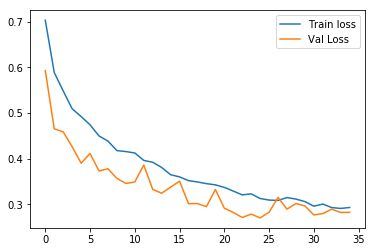

In [42]:
# put in early stopping

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

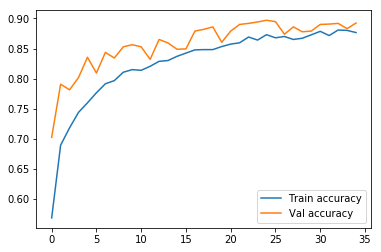

In [43]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

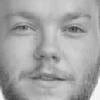

In [64]:
array_to_img(X_test[100])

In [65]:
model.predict(X_test[100:101])

NameError: name 'model' is not defined

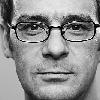

In [46]:
array_to_img(X_test[5])

In [47]:
# [no smile, smile]
model.predict(X_test[5:6])

array([[0.296994, 0.703006]], dtype=float32)

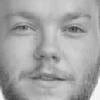

In [48]:
array_to_img(X_test[100])

In [49]:
model.predict(X_test[100:101])

array([[0.80920535, 0.19079466]], dtype=float32)

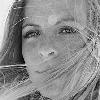

In [50]:
array_to_img(X_test[102])

In [51]:
X_test[102:103].shape

(1, 100, 100, 1)

In [52]:
X_test[102:103]

array([[[[0.9215687 ],
         [0.9176471 ],
         [0.91372555],
         ...,
         [0.5254902 ],
         [0.44705886],
         [0.46274513]],

        [[0.9215687 ],
         [0.9176471 ],
         [0.91372555],
         ...,
         [0.6       ],
         [0.4666667 ],
         [0.57254905]],

        [[0.9215687 ],
         [0.9176471 ],
         [0.91372555],
         ...,
         [0.6392157 ],
         [0.41960788],
         [0.48235297]],

        ...,

        [[0.7607844 ],
         [0.7803922 ],
         [0.7607844 ],
         ...,
         [0.40784317],
         [0.6627451 ],
         [0.6392157 ]],

        [[0.78823537],
         [0.7960785 ],
         [0.78823537],
         ...,
         [0.4431373 ],
         [0.6627451 ],
         [0.65882355]],

        [[0.8000001 ],
         [0.7960785 ],
         [0.8000001 ],
         ...,
         [0.43137258],
         [0.6431373 ],
         [0.6745098 ]]]], dtype=float32)

In [53]:
model.predict(X_test[102:103])

array([[0.22031793, 0.7796821 ]], dtype=float32)

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

In [55]:
from tensorflow.keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
del model  

# Bringing in new image

In [56]:
from PIL import Image
import face_recognition
from tensorflow.keras.preprocessing.image import img_to_array
import h5py
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
img_width, img_height = (100, 100)

# returns a compiled model
# identical to the previous one
# Returns a compiled model identical to the previous one
new_model = load_model('my_model.h5')
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
def predict_smile (file_name):

    new_img = Image.open(file_name)

    # reshape
    new_img_greyscale = new_img.convert("L")
    print(img_to_array(new_img_greyscale).shape)
    
    # load image into a numpy array
    new_image = face_recognition.load_image_file(file_name)
    face_locations = face_recognition.face_locations(new_image) # model = 'cnn' (more accurate but way slower)
    if len(face_locations) == 1:
        top, right, bottom, left = face_locations[0]
        box = (left, top, right, bottom)
        new_img_resized = new_img_greyscale.resize((img_width, img_height), box = box)
        new_img_resized.save(f'preprocessed_{file_name}')
    else:
        print('Image must have 1 person')

    img = Image.open(f'preprocessed_{file_name}')

    new_img_array = img_to_array(img)
    
    new_img_array = np.array(new_img_array)
    
    new_img_array = new_img_array.reshape(1, img_width*img_height)
    
    new_img_array = scaler.transform(new_img_array)
    
    new_img_array = new_img_array.reshape(1, img_width, img_height, 1)
    
    return new_img_array

(147, 220, 1)
(183, 275, 1)
(273, 185, 1)
(194, 259, 1)
(612, 473, 1)
(217, 232, 1)
(225, 225, 1)
(183, 275, 1)
(223, 226, 1)
(183, 275, 1)
(225, 225, 1)


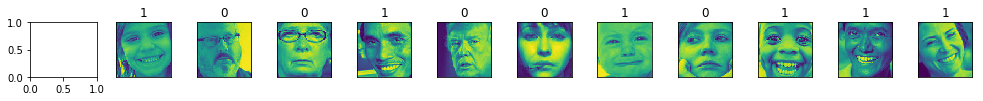

In [81]:
_, image = plt.subplots(1, 12, figsize=(17, 1))

for pic in range(1,12):
    pic_array = predict_smile(f'test{pic}.jpg')
    image[pic].imshow(pic_array.reshape(img_width, img_height))
    image[pic].set_title(np.argmax(new_model.predict(pic_array)))
    image[pic].set_xticks([])
    image[pic].set_yticks([])

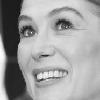

In [74]:
array_to_img(X_test[500])

In [75]:
new_model.predict(X_test[500:501])

array([[0.00821791, 0.99178207]], dtype=float32)